In [1]:
import os
import pickle
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pybullet as p
import tensorflow as tf
from scipy.spatial import ConvexHull

from ravens.utils import utils


pybullet build time: May 20 2022 19:43:01
2022-12-24 09:49:35.120694: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
COLORS = {
    "blue": [078.0 / 255.0, 121.0 / 255.0, 167.0 / 255.0],
    "red": [255.0 / 255.0, 087.0 / 255.0, 089.0 / 255.0],
    "green": [089.0 / 255.0, 169.0 / 255.0, 079.0 / 255.0],
    "orange": [242.0 / 255.0, 142.0 / 255.0, 043.0 / 255.0],
    "yellow": [237.0 / 255.0, 201.0 / 255.0, 072.0 / 255.0],
    "purple": [176.0 / 255.0, 122.0 / 255.0, 161.0 / 255.0],
    "pink": [255.0 / 255.0, 157.0 / 255.0, 167.0 / 255.0],
    "cyan": [118.0 / 255.0, 183.0 / 255.0, 178.0 / 255.0],
    "brown": [156.0 / 255.0, 117.0 / 255.0, 095.0 / 255.0],
    "gray": [186.0 / 255.0, 176.0 / 255.0, 172.0 / 255.0],
}


def plot(
    title,
    ylabel,
    xlabel,
    data,
    ax,
    xlim=[-np.inf, 0],
    xticks=None,
    ylim=[np.inf, -np.inf],
    show_std=True,
):
    """Plot frame data."""
    # Data is a dictionary that maps experiment names to tuples with 3
    # elements: x (size N array) and y (size N array) and y_std (size N array)

    # Get data limits.
    for name, (x, y, _) in data.items():
        del name
        y = np.array(y)
        xlim[0] = max(xlim[0], np.min(x))
        xlim[1] = max(xlim[1], np.max(x))
        ylim[0] = min(ylim[0], np.min(y))
        ylim[1] = max(ylim[1], np.max(y))

    # Draw background.
    ax.set_title(title, fontsize=14)
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.set_xlim(xlim)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.grid(True, linestyle="-", color=[0.8, 0.8, 0.8])
    _ax = plt.gca()
    for axis in ["top", "bottom", "left", "right"]:
        _ax.spines[axis].set_color("#000000")
    plt.rcParams.update({"font.size": 14})
    plt.rcParams["mathtext.default"] = "regular"
    matplotlib.rcParams["pdf.fonttype"] = 42
    matplotlib.rcParams["ps.fonttype"] = 42

    # Draw data.
    color_iter = 0
    for name, (x, y, std) in data.items():
        del name
        x, y, std = np.float32(x), np.float32(y), np.float32(std)
        upper = np.clip(y + std, ylim[0], ylim[1])
        lower = np.clip(y - std, ylim[0], ylim[1])
        color = COLORS[list(COLORS.keys())[color_iter]]
        if show_std:
            ax.fill_between(x, upper, lower, color=color, linewidth=0, alpha=0.3)
        ax.plot(x, y, color=color, linewidth=2, marker="o", alpha=1.0)
        color_iter += 1

    if xticks:
        ax.set_xticks(ticks=range(len(xticks)), labels=xticks)
    ax.legend([name for name, _ in data.items()], loc="lower right", fontsize=14)
    plt.tight_layout()


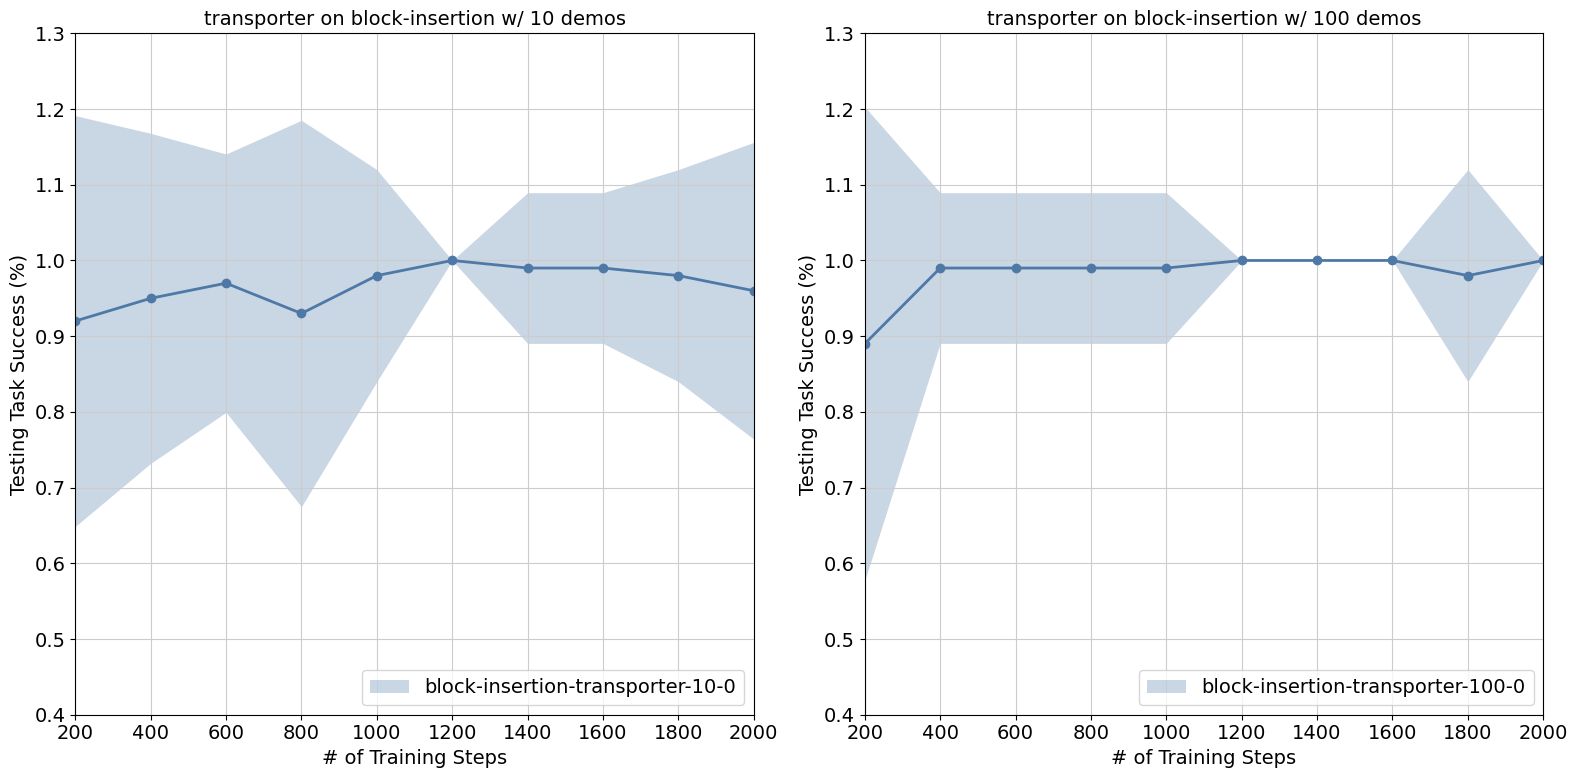

In [23]:
task = "block-insertion"
agent = "transporter"
train_run = 0
logs = {}

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for index, n_demos in enumerate([10, 100]):
    path_to_predictions = Path(f"predictions/{task}-{agent}-{n_demos}-{train_run}/")
    name = f"{task}-{agent}-{n_demos}-{train_run}"

    # Load and print results to console.
    curve = []
    for fname in tf.io.gfile.listdir(str(path_to_predictions)):
        fname = os.path.join(str(path_to_predictions), fname)
        if name in fname and ".pkl" in fname:
            n_steps = int(fname[(fname.rfind("-") + 1) : -4])
            data = pickle.load(open(fname, "rb"))
            rewards = []
            for reward, _ in data:
                rewards.append(reward)
            score = np.mean(rewards)
            std = np.std(rewards)
            curve.append((n_steps, score, std))
        curve.sort()

    # Plot results over training steps.
    title = f"{agent} on {task} w/ {n_demos} demos"
    ylabel = "Testing Task Success (%)"
    xlabel = "# of Training Steps"
    curve = np.array(curve)
    logs = {name: (curve[:, 0], curve[:, 1], curve[:, 2])}
    plot(title, ylabel, xlabel, data=logs, ax=axs[index], ylim=[0.4, 1.3])


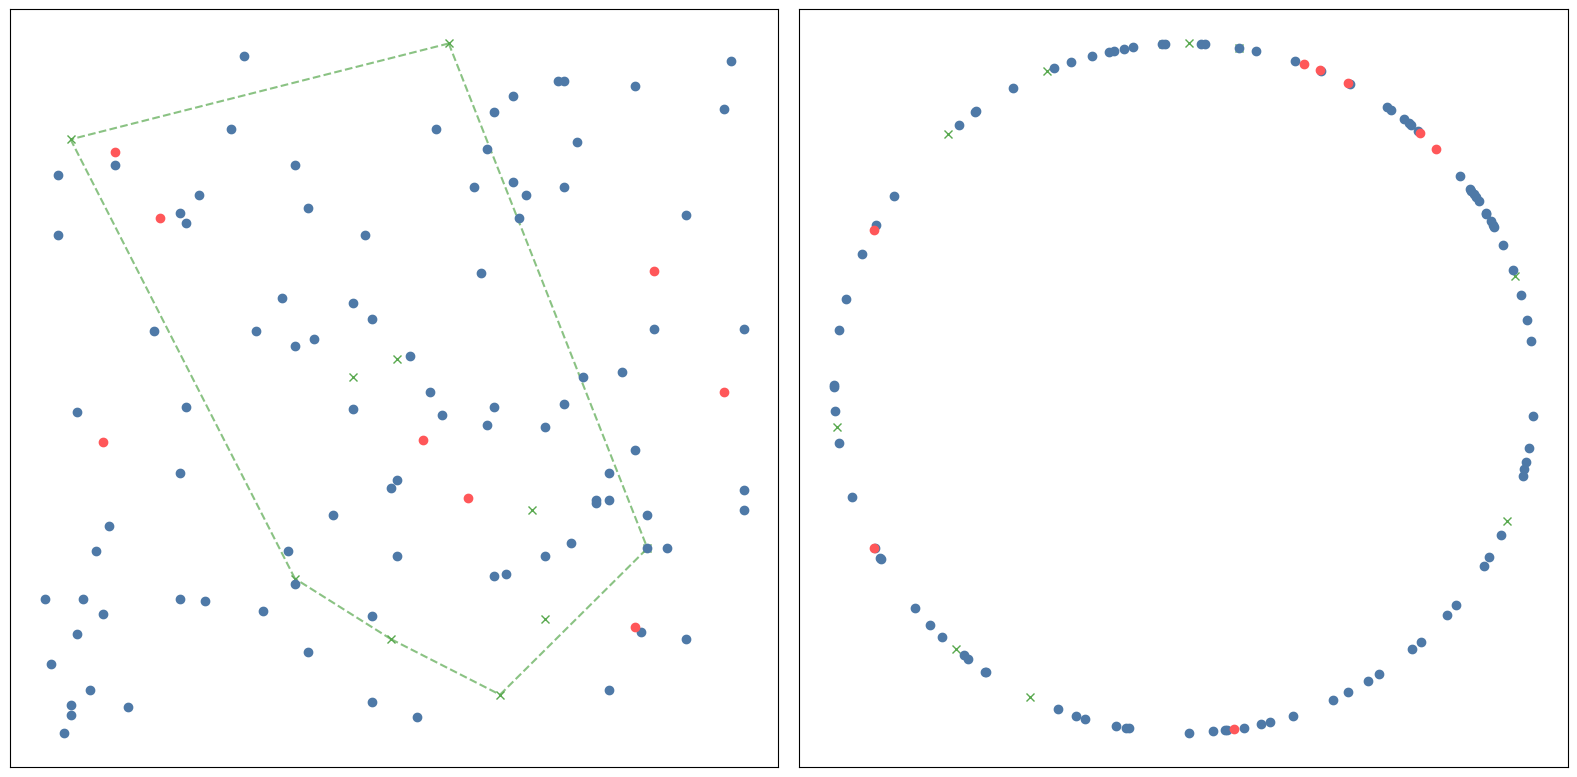

In [8]:
np.random.seed(train_run)
tf.random.set_seed(train_run)

episodes = np.random.choice(1000, n_demos, False)
path_to_infos = Path("dataset/block-insertion-train/info/")

data = pickle.load(
    open(
        path_to_predictions
        / f"{task}-{agent}-{n_demos}-{train_run}-200.pkl",
        "rb",
    )
)

place_positions = {-1: [], 0: [], 1: []}
place_orientations = {-1: [], 0: [], 1: []}
for episode in episodes:
    info_path = [
        f for f in path_to_infos.glob("{:>6}*.pkl".format(episode).replace(" ", "0"))
    ][0]
    with open(info_path, "rb") as file:
        info = pickle.load(file)
    place_positions[-1].append(info[0][6][0])
    place_orientations[-1].append(p.getEulerFromQuaternion(info[0][6][1]))

for episode_info in data:
    place_positions[episode_info[0]].append(episode_info[1][6][0])
    place_orientations[episode_info[0]].append(
        p.getEulerFromQuaternion(episode_info[1][6][1])
    )

place_positions = {k: np.array(v)[:, :2] for k, v in place_positions.items()}
place_orientations = {k: np.array(v)[:, 2] for k, v in place_orientations.items()}
hull = ConvexHull(place_positions[-1])

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].plot(
    place_positions[-1][:, 0],
    place_positions[-1][:, 1],
    "x",
    color=COLORS["green"],
    alpha=1,
)
for simplex in hull.simplices:
    axs[0].plot(
        place_positions[-1][simplex, 0],
        place_positions[-1][simplex, 1],
        "--",
        color=COLORS["green"],
        alpha=0.7,
    )
axs[0].plot(
    place_positions[1][:, 0],
    place_positions[1][:, 1],
    "o",
    color=COLORS["blue"],
)
axs[0].plot(
    place_positions[0][:, 0], place_positions[0][:, 1], "o", color=COLORS["red"]
)


axs[1].plot(
    np.real(np.exp(1j * place_orientations[-1])),
    np.imag(np.exp(1j * place_orientations[-1])),
    "x",
    color=COLORS["green"],
    alpha=1,
)
axs[1].plot(
    np.real(np.exp(1j * place_orientations[1])),
    np.imag(np.exp(1j * place_orientations[1])),
    "o",
    color=COLORS["blue"],
)
axs[1].plot(
    np.real(np.exp(1j * place_orientations[0])),
    np.imag(np.exp(1j * place_orientations[0])),
    "o",
    color=COLORS["red"],
)
axs[0].tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)

axs[1].tick_params(
    axis="both",
    left=False,
    top=False,
    right=False,
    bottom=False,
    labelleft=False,
    labeltop=False,
    labelright=False,
    labelbottom=False,
)
plt.tight_layout()

In [36]:
all_n_steps = []
path_to_checkpoints = Path("checkpoints/manipulating-rope-transporter-10-0")
files = [f for f in path_to_checkpoints.glob("**/*") if f.is_file()]
for file in files:
    # print(file)
    n_steps = int(str(file.stem).split("-")[-1])
    if n_steps == 3050 or n_steps % 400 == 0:
        if n_steps not in all_n_steps:
            all_n_steps.append(n_steps)
            print(
                f"python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps={n_steps} --data_dir=../dataset/ --root_dir=../"
            )


python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=2800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=400 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=3050 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=10 --n_steps=1200 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environ

In [33]:
len(all_n_steps)

9

In [ ]:
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=2800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=1400 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=3600 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=3000 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=600 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=3200 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=3800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=400 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=50 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=1000 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=1800 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=200 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=1200 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=2000 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=2200 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=2400 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=3400 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=1600 --data_dir=../dataset/ --root_dir=../
python ravens/test.py --assets_root=./ravens/environments/assets/ --disp=False --task=manipulating-rope --agent=transporter --n_demos=100 --n_steps=2600 --data_dir=../dataset/ --root_dir=../